### 📄 Reference Paper  
**Title:** *Enhancing fraud detection and prevention in fintech: Big data and machine learning approaches*  
**Link:** [Read on ResearchGate](https://www.researchgate.net/publication/386250683_Enhancing_fraud_detection_and_prevention_in_fintech_Big_data_and_machine_learning_approaches)


# **by : Ahmed Ibrahim Foda - 202202064**

# Importing Libraries & Dataset

In [1]:
pip install lime

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.inspection import PartialDependenceDisplay

| **Column Name**      | **Description**                                                                                                         |
|----------------------|-------------------------------------------------------------------------------------------------------------------------|
| `step`               | Time step — A unit of time in the simulation. 1 step = 1 hour. The simulation spans 744 steps (30 days).               |
| `type`               | Transaction type — One of: `CASH-IN`, `CASH-OUT`, `DEBIT`, `PAYMENT`, or `TRANSFER`.                                  |
| `amount`             | Transaction amount — The amount of money moved in the transaction, in local currency.                                 |
| `nameOrig`           | Origin account ID — The ID of the customer/account initiating the transaction. Example: `C429214117`                  |
| `oldbalanceOrg`      | Origin account balance before — The balance of the origin account before the transaction.                             |
| `newbalanceOrig`     | Origin account balance after — The balance of the origin account after the transaction.                               |
| `nameDest`           | Destination account ID — The ID of the customer/account receiving the money. Merchant IDs often start with `M`.       |
| `oldbalanceDest`     | Destination balance before — The balance of the recipient account before the transaction.                             |
| `newbalanceDest`     | Destination balance after — The balance of the recipient account after the transaction.                               |
| `isFraud`            | Fraudulent transaction — `1` if the transaction was fraudulent, otherwise `0`.                                        |
| `isFlaggedFraud`     | Flagged by model — `1` if the transaction was flagged as potentially fraudulent (e.g., over 200,000 units), otherwise `0`. |


In [3]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the correct path to the file inside the dataset
file_path = "PS_20174392719_1491204439457_log.csv"

# Load the dataset
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "ealaxi/paysim1",
  file_path,
)

<ipython-input-3-6f78741f7575>:8: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# Data Preprocessing & EDA

In [5]:
len(df)

6362620

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [8]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [9]:
print("\nFraud Distribution:")
print(df['isFraud'].value_counts())


Fraud Distribution:
isFraud
0    6354407
1       8213
Name: count, dtype: int64


In [10]:
df["nameOrig"].nunique()

6353307

In [11]:
df["nameDest"].nunique()

2722362

### I will drop the features `nameOrig` & `nameDist` as they don't introduce any pattern also they are categorical and not ordinal features with unique values of `6353307` and `2722362` respictivly which means that after applying One-Hot Encoding we will have huge amount of 0,1 columns.

In [12]:
df.drop(columns=["nameOrig", "nameDest"],inplace=True)

### I will drop the feature `isFlaggedFraud` as it's a rule based pre-defined to flag a transaction as a fraud based on some rule which may cause data leakage

In [13]:
df.drop(columns=["isFlaggedFraud"],inplace=True)
df.columns

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud'],
      dtype='object')

In [14]:
df.duplicated().sum()

np.int64(543)

In [15]:
df.drop_duplicates(inplace=True)

In [16]:
df.isna().sum()

,0
step,0
type,0
amount,0
oldbalanceOrg,0
newbalanceOrig,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [17]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


# Feature Engineering

In [18]:
df['hour_of_day'] = df['step'] % 24
df['day_of_week'] = (df['step'] // 24) % 7
df['day_of_month'] = df['step'] // 24

In [19]:
def hour_bin(hour):
    if 0 <= hour < 6:
        return 'night'
    elif 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    else:
        return 'evening'

df['time_of_day'] = df['hour_of_day'].apply(hour_bin)

In [20]:
df.drop(columns=['step'], inplace=True)

In [21]:
df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,hour_of_day,day_of_week,day_of_month,time_of_day
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,1,0,0,night
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,1,0,0,night
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,1,0,0,night
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,1,0,0,night
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,1,0,0,night


In [22]:
df = pd.get_dummies(df, columns=['type','time_of_day'], prefix='type')

# Modeling

## Model Training & Testing

In [45]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [35]:
full_sample_size = 6353880
n_per_class_full = 1000000
fraud_indices = np.random.choice(np.where(y_resampled == 1)[0], n_per_class_full, replace=False)
non_fraud_indices = np.random.choice(np.where(y_resampled == 0)[0], n_per_class_full, replace=False)
sample_indices = np.concatenate([fraud_indices, non_fraud_indices])
X_sampled = X_resampled.iloc[sample_indices]
y_sampled = y_resampled.iloc[sample_indices]

In [49]:
len(X_sampled)

2000000

In [50]:
# Define individual models
lr = LogisticRegression(random_state=42)
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [51]:
# Hybrid classifier
hybrid_clf = VotingClassifier(estimators=[('lr', lr), ('dt', dt), ('rf', rf)], voting='soft')

In [52]:
# Train hybrid model
hybrid_clf.fit(X_sampled, y_sampled)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('dt', DecisionTreeClassifier(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42))],
                 voting='soft')

In [53]:
# Model Testing
y_pred = hybrid_clf.predict(X_test)
y_pred_proba = hybrid_clf.predict_proba(X_test)[:, 1]

## Model Evaluation

In [54]:
# Calculate different accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print metrics
print("Model Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Model Performance Metrics:
Accuracy: 0.9992
Precision: 0.6135
Recall: 0.9736
F1 Score: 0.7527


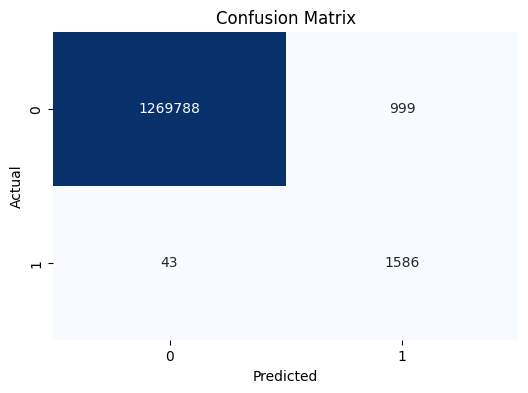

In [55]:
# Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### According to the performance metrics and the confusion matrix the model performance is good as from `1270787` non fraud record it successfully predicted `1269788` record correctly while for the fraud class of `1629` record it successfully predicited `1586` while missed `43` record.


# Explainability

## LIME Explanation

In [58]:
X_sampled = X_sampled.values
X_test = X_test.values
y_sampled = y_sampled.values
y_test = y_test.values

In [59]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_sampled, feature_names=X.columns, class_names=["Non-Fraud", "Fraud"], mode="classification"
)
lime_exp = lime_explainer.explain_instance(X_test[0], hybrid_clf.predict_proba, num_features=5)
lime_exp.show_in_notebook()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [60]:
y_test[0]

np.int64(0)

### According to lime explaining for this record it shows the `newbalanceOrig`, `oldbalanceOrg` and the `type_night` are the features that contribute to the model results the most so that it helped the model predicting this record correctly as a non fraud.

## Feature Importance from Random Forest

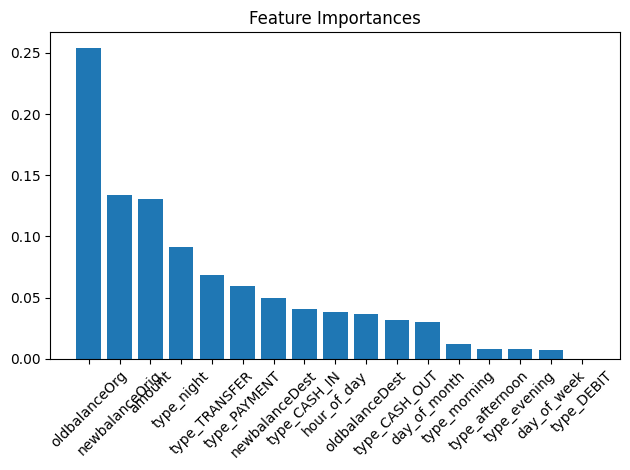

In [74]:
rf.fit(X_train, y_train)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45)
plt.tight_layout()
plt.show()

### For the random forest the most 3 important features are `newbalanceOrig`,`oldbalanceOrg` and `type_night`.

## PDP Plot

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(hybrid_clf, X_train, features=[0, 1], feature_names=X.columns, ax=ax)
plt.savefig("pdp_plot.png")

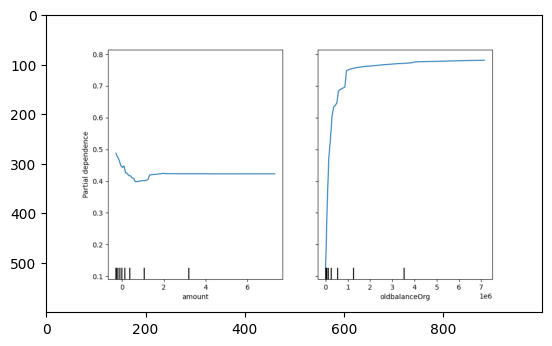

In [77]:
img = mpimg.imread('pdp_plot.png')  # e.g., 'sample.jpg' or '/kaggle/input/your-image.png'
plt.imshow(img)

### From the PDP plot of those 2 features we can conclude that for the `amount` column at the small amount the probability of fraud is high but as the amount increases the probability setteles at 0.42 while for the `oldBalanceOrg` as the value increases the probility of being fraud increases.

## ICE Plot

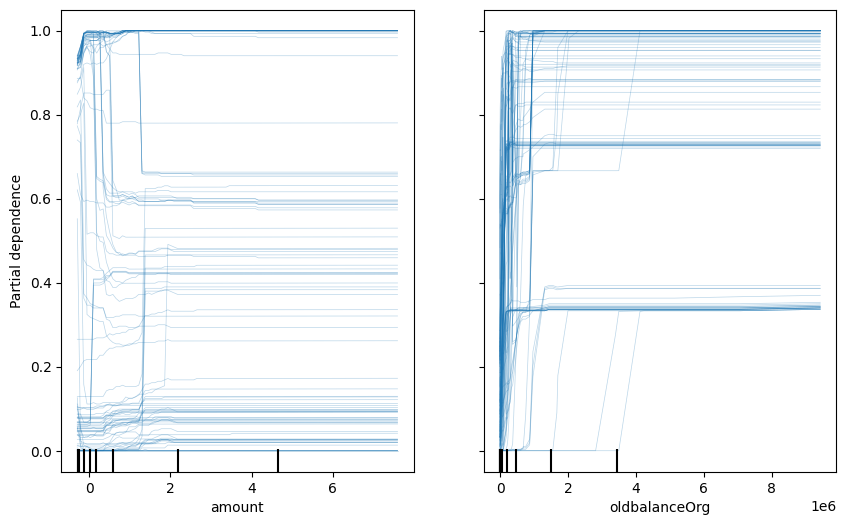

In [78]:
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    hybrid_clf, X_train[:100], features=[0, 1], feature_names=X.columns, kind='individual', ax=ax
)
plt.savefig("ice_plot.png")

### From the ICE plot of those 2 features we can conclude that for the `amount` column most of the lines drop meaning the probabbility of being fraud decreases but for the `oldBalanceOrg` as the value increases the lines goes up meaning that the probability of being fraud increases.